# Preliminary Exploration

## White noise

White noise is random, but characterized by a Gaussian distribution about a mean. Plotting white noise as a histogram reveals this behavior:

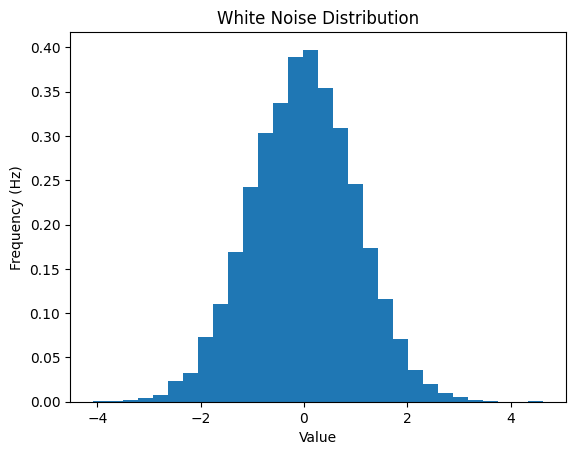

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def white_noise(mean, std_dev, num_samples):
    return np.random.normal(mean, std_dev, num_samples)

def plot_white_noise_hist(mean, std_dev, num_samples, bins=30):
    # Generate noise
    noise = white_noise(mean, std_dev, num_samples)

    # Plot noise histogram
    plt.figure()
    plt.hist(noise, bins, density=True)
    plt.title('White Noise Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency (Hz)')
    plt.show()

plot_white_noise_hist(0, 1, 10000)

This can be transformed into a histogram to show what a signal of white noise might look like:

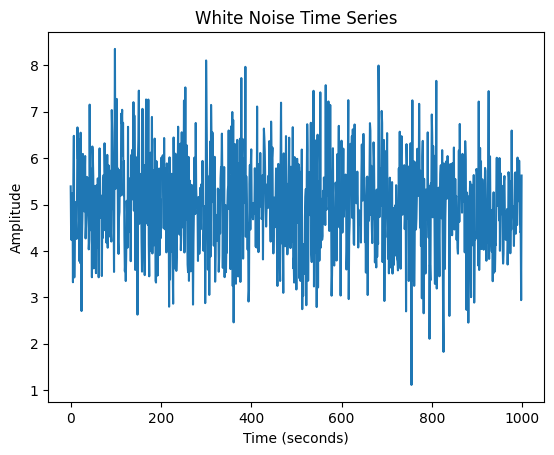

In [2]:
def plot_white_noise_time_series(mean, std_dev, num_samples):
    # Generate noise
    noise = white_noise(mean, std_dev, num_samples)

    # Generate time axis
    time = np.arange(num_samples)

    # Plot noise as a time series
    plt.figure()
    plt.plot(time, noise)
    plt.title('White Noise Time Series')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

plot_white_noise_time_series(5, 1, 1000)

A signal like this can then be converted into a PSD (Power Spectrum Diagram), which shows how powerful different frequencies are in the signal. Because this is white noise, the signal should be roughly equivalently powerful across different frequencies.

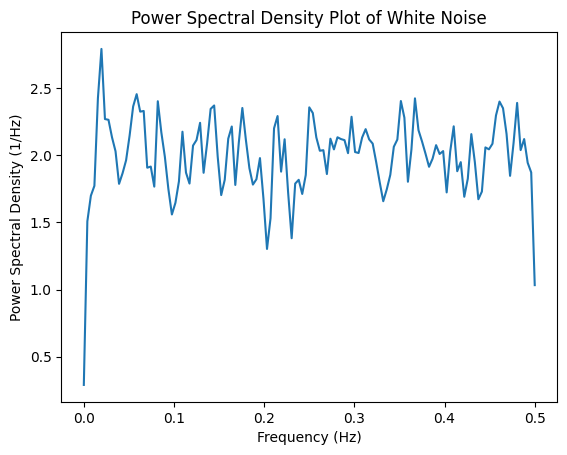

In [3]:
def plot_white_noise_psd(mean, std_dev, num_samples):
    # Generate noise
    noise = white_noise(mean, std_dev, num_samples)

    # Apply Welch's Method
    (frequencies, psds) = signal.welch(noise)

    # Plot PSD graph
    plt.figure()
    plt.plot(frequencies, psds)
    plt.title('Power Spectral Density Plot of White Noise')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Power Spectral Density (1/Hz)')
    plt.show()

plot_white_noise_psd(5, 1, 10000)

## Frequency-dependent noise

In real gravitational wave detectors, noise is frequency-dependent. Some noise might be white, but other factors influence the noise in particular ways. For example, seismic waves cause large amounts of noise at low frequencies. While not perfect, the curve you might see if you made a PSD from the gravitational wave detectors could look something like this:

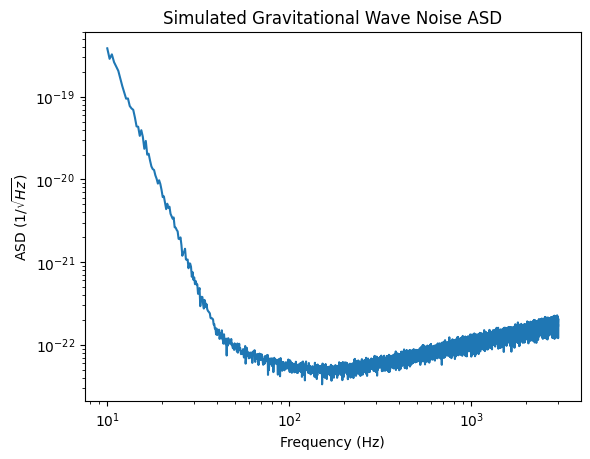

In [4]:
def noise_curvify(input):
    result = []
    for x in input:
        result.append(
            (3.63*10**-22)*((0.3*(x/40)**-6)**2 + (0.3*(x/40)**(-1))**2 + (0.1*(x/120)**0.5)**2)**(1/2)
        )
    return result

def plot_noisy_curve():
    inputs = np.linspace(10, 3000, 10000)
    noise = white_noise(1, 0.1, 10000)
    curve = noise_curvify(inputs) * noise

    plt.figure()
    plt.loglog(inputs, curve)
    plt.title('Simulated Gravitational Wave Noise ASD')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'ASD (1/$\sqrt{Hz}$)')
    plt.show()

plot_noisy_curve()

This can be converted back into a wave for frequency-dependent noise:

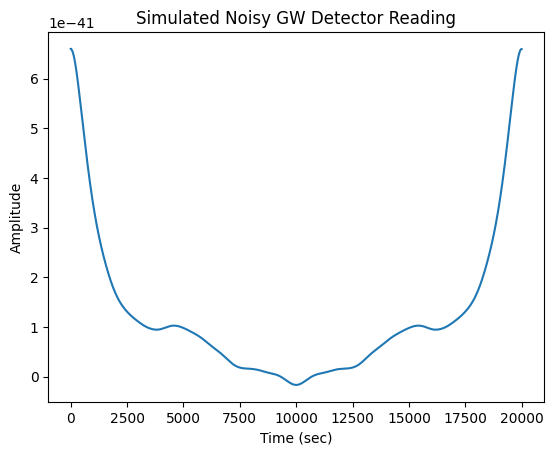

In [5]:
def plot_noisy_freq_dep_wave():
    inputs = np.linspace(10, 3000, 10000)
    noise = white_noise(1, 0.1, 10000)
    asd = noise_curvify(inputs) * noise
    psd = asd ** 2
    wave = np.real(np.fft.irfft(psd))
    times = np.arange(1, len(wave) + 1)
    
    plt.figure()
    plt.plot(times, wave)
    plt.title('Simulated Noisy GW Detector Reading')
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.show()

plot_noisy_freq_dep_wave()

Using the inverse fourier transform is not quite correct, since it uses complex values, but the noisy signal here is completely real. This leads to the symmetry seen above. In this case, only the range from 0 to half the full range (10000) should be interpreted.

## Real GWOSC data

Real data can be obtained from GWOSC using the `gwpy` library. Getting data is easy, and can be done using the `TimeSeries.fetch_open_data()` method:

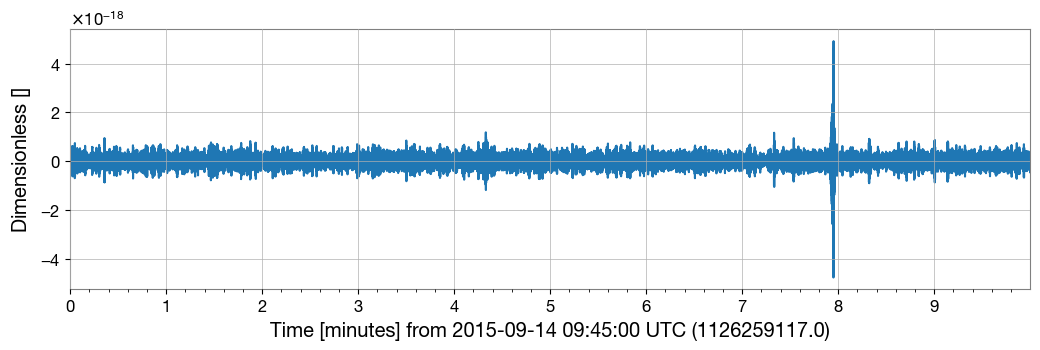

In [8]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot

detector_data = TimeSeries.fetch_open_data('H1', 1126259117, 1126259717)

def plot_real_sample_time_series():
    ldata = detector_data
    ldata.plot().show()

plot_real_sample_time_series()

The time series can also be converted into a PSD:

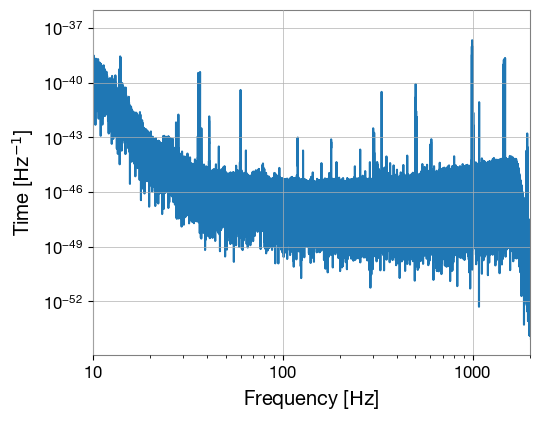

In [10]:
def plot_real_sample_psd():
    ldata = detector_data
    psd = ldata.psd().plot()
    psd.gca().set_xlim(10, 2000)
    psd.show()

plot_real_sample_psd()

Or an ASD:

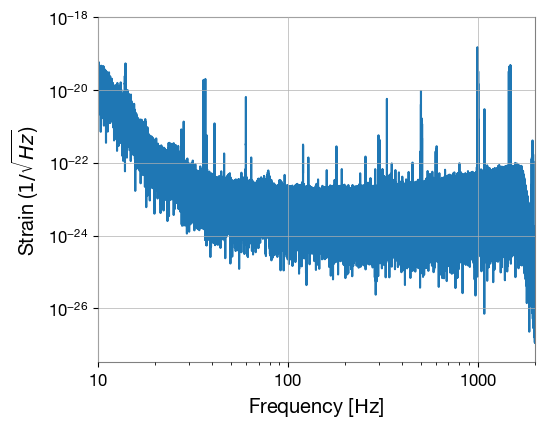

In [13]:
def plot_real_sample_asd():
    data = detector_data
    asd = data.asd().plot(ylabel=r'Strain ($1/\sqrt{Hz}$)')
    asd.gca().set_xlim(10, 2000)
    asd.show()

plot_real_sample_asd()

You can also plot a spectrogram:

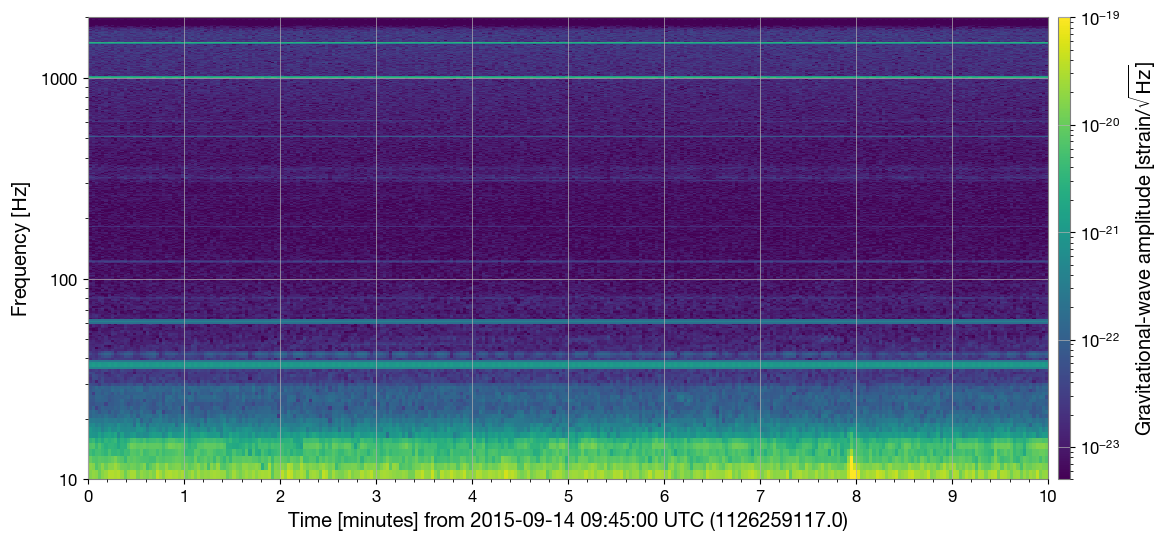

In [16]:
def plot_real_sample_spectrogram():
    data = detector_data
    spectrogram = data.spectrogram(2, fftlength=1, overlap=0.5) ** 0.5

    plot = spectrogram.imshow(norm='log', vmin=5e-24, vmax=1e-19)
    axes = plot.gca()
    axes.set_yscale('log')
    axes.set_ylim(10, 2000)
    axes.colorbar(
        label=r'Gravitational-wave amplitude [strain/$\sqrt{\mathrm{Hz}}$]')
    plot.show()

plot_real_sample_spectrogram()